In [1]:
import random
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import botorch

sns.set(style='whitegrid', font_scale=1.75)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.double

In [2]:
import botorch
import sys
sys.path.insert(0, '..')

from scipy import stats

from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import (
    ExpectedImprovement,
    NoisyExpectedImprovement,
    UpperConfidenceBound,
)
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
    qUpperConfidenceBound,
)
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.acquisition.objective import IdentityMCObjective
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import IIDNormalSampler, SobolQMCNormalSampler
from botorch.models import SingleTaskGP

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval

from conformalbo.ratio_estimation import RatioEstimator
from conformalbo.helpers import (
    assess_coverage,
    construct_conformal_bands,
    conf_mask_to_bounds,
)
from conformalbo.acquisitions import (
    # conformalize_acq_fn,
    qConformalKnowledgeGradient,
    qConformalUpperConfidenceBound,
    qConformalExpectedImprovement,
    qConformalNoisyExpectedImprovement
)

from lambo.utils import DataSplit, update_splits
from lambo.optimizers.pymoo import Normalizer

In [3]:
obj_fn = lambda x: np.maximum(0.25 * x - 0.125 * x ** 2 + 32 * np.cos(x), 0)

noise_scale = 4.
x_bounds = torch.tensor((-16., 16.), dtype=dtype).view(-1, 1)
target_dim = 1
input_bounds = torch.tensor([-1., 1.], device=DEVICE, dtype=dtype).view(-1, 1)

Text(0.5, 0, 'x')

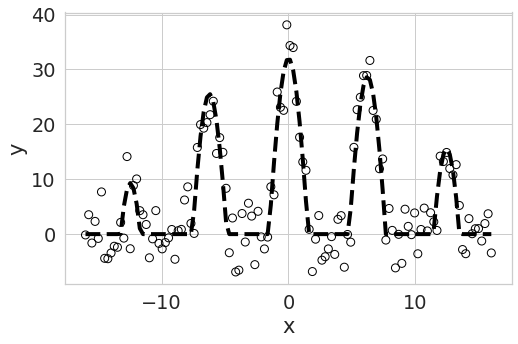

In [4]:
fig = plt.figure(figsize=(8, 5))

x = np.linspace(*x_bounds, 128)
f = obj_fn(x)
y = f + noise_scale * np.random.randn(*f.shape)

plt.scatter(x, y, edgecolors='black', facecolors='none', label='observations', s=64, zorder=2)
plt.plot(x, f, color='black', linestyle='--', label='ground truth', linewidth=4, zorder=3)

plt.ylabel('y')
plt.xlabel('x')
# plt.ylim((-4, 24))
# plt.legend(loc='upper left', ncol=2)

In [5]:
x = (x - x.min()) / (x.max() - x.min())
f = (f - y.min()) / (y.max() - y.min())
y = (y - y.min()) / (y.max() - y.min())

perm = np.random.permutation(x.size)
train_inputs = torch.tensor(x[perm][:4], device=DEVICE, dtype=dtype).view(-1, 1)
train_targets = torch.tensor(y[perm][:4], device=DEVICE, dtype=dtype).view(-1, 1)

matern_gp = SingleTaskGP(
    train_X=train_inputs,
    train_Y=train_targets,
    likelihood=GaussianLikelihood(noise_constraint=Interval(5e-2, 0.5)),
).to(DEVICE)
mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
fit_gpytorch_model(mll)
matern_gp.requires_grad_(False)

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Interval(5.000E-02, 5.000E-01)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

In [6]:
q_grid_res = 16
x1 = torch.linspace(0, 1, steps=q_grid_res, device=DEVICE, dtype=dtype)
x2 = torch.linspace(0, 1, steps=q_grid_res, device=DEVICE, dtype=dtype)
x1, x2 = torch.meshgrid(x1, x2, indexing='xy')
x_grid = torch.stack([x1.reshape(-1), x2.reshape(-1)], dim=-1)

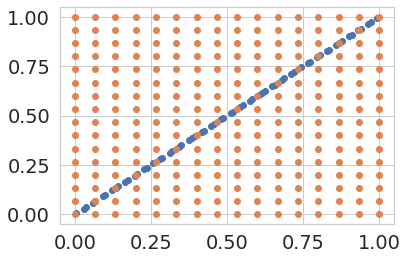

In [7]:
mc_samples = 64

sobol_eng = torch.quasirandom.SobolEngine(dimension=1, scramble=True)
X_fantasy = sobol_eng.draw(mc_samples).to(x_grid)[np.random.permutation(mc_samples)]
X_fantasy = X_fantasy.expand(x_grid.shape[0], -1, -1)
# X_fantasy = torch.stack(
#     [X_fantasy[np.random.permutation(mc_samples)] for _ in range(x_grid.shape[0])]
# )
kg_inputs = torch.cat([x_grid[..., None], X_fantasy], dim=-2)

samples = sobol_eng.draw(mc_samples).view(-1)
plt.scatter(samples, samples)
plt.scatter(x_grid[:, 0].cpu(), x_grid[:, 1].cpu())

In [8]:
collapse_batch_dims = True

sampler = IIDNormalSampler(mc_samples, collapse_batch_dims=collapse_batch_dims)
# sampler = SobolQMCNormalSampler(mc_samples)

inner_sampler = IIDNormalSampler(2 * mc_samples, collapse_batch_dims=collapse_batch_dims)
# inner_sampler = SobolQMCNormalSampler(mc_samples)

In [9]:
base_name = 'qUCB'
base_kwargs = dict(
    model=matern_gp,
    sampler=sampler,
)

if base_name == 'qEI':
    base_acq = qExpectedImprovement(
        **base_kwargs,
        best_f=f[perm][:4].max(),
    )
elif base_name == 'qNEI':
    base_acq = qNoisyExpectedImprovement(
        **base_kwargs,
        X_baseline=train_inputs,
    )
elif base_name == 'qUCB':
    base_acq = qUpperConfidenceBound(
        **base_kwargs,
        beta=1.,
    )
elif base_name == 'qKG':
    base_acq = qKnowledgeGradient(
        **base_kwargs,
        num_fantasies=mc_samples,
        objective=IdentityMCObjective(),
        inner_sampler=inner_sampler,
    )

    
conf_name = 'qCUCB'
conformal_kwargs = dict(
    alpha=1. / math.sqrt(train_inputs.size(0)),
    temp=1e-4,
    grid_res=mc_samples,
    max_grid_refinements=0,
    ratio_estimator=None,
    grid_sampler=IIDNormalSampler(
        mc_samples, collapse_batch_dims=collapse_batch_dims
    )
#     grid_sampler = SobolQMCNormalSampler(grid_res)
)

if conf_name == 'qCEI':
    conf_acq = qConformalExpectedImprovement(
        **conformal_kwargs,
        **base_kwargs,
        best_f=f[perm][:4].max(),
    )
elif conf_name == 'qCNEI':
    conf_acq = qConformalNoisyExpectedImprovement(
        **conformal_kwargs,
        **base_kwargs,
        X_baseline=train_inputs,
    )
elif conf_name == 'qCUCB':
    conf_acq = qConformalUpperConfidenceBound(
        **conformal_kwargs,
        optimistic=True,
        **base_kwargs,
        beta=1.,
    )
elif conf_name == 'qCKG':
    conf_acq = qConformalKnowledgeGradient(
        **conformal_kwargs,
        model=matern_gp,
#         sampler=IIDNormalSampler(mc_samples, batch_range=(0, -3)),
        num_fantasies=mc_samples,
        objective=IdentityMCObjective(),
        inner_sampler=IIDNormalSampler(2 * mc_samples, collapse_batch_dims=collapse_batch_dims),
    )

In [10]:
num_samples = 1
base_acq_vals = 0.
conf_acq_vals = 0.
for _ in range(num_samples):
#     with torch.no_grad():
#         base_acq_vals += base_acq(x_grid[..., None]) / num_samples
#         conf_acq_vals += conf_acq(x_grid[..., None]) / num_samples
#     bounds = torch.tensor([[0.], [1.]]).to(x_grid)
    base_acq_vals += base_acq(kg_inputs) / num_samples
    conf_acq_vals += conf_acq(kg_inputs) / num_samples

/home/sam/miniconda3/envs/conf-bo-env/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
/home/sam/miniconda3/envs/conf-bo-env/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


/tmp/ipykernel_20383/673911424.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cbar)


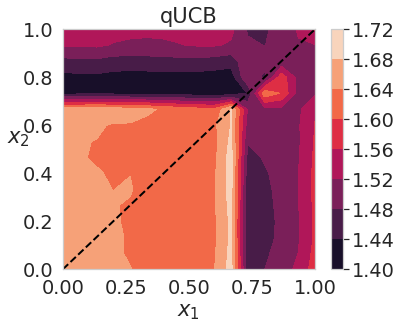

In [11]:
fig = plt.figure(figsize=(6, 5))

# ax = plt.axes(projection='3d')
# ax.plot_surface(x1.cpu(), x2.cpu(), z.cpu())

ax = fig.add_subplot(1, 1, 1)
ax.set_title(base_name)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$', rotation=0)
z = base_acq_vals.reshape(q_grid_res, q_grid_res)
contour_kwargs = dict()
#     vmin=0,
#     vmax=0.06,
# )
cbar = ax.contourf(x1.cpu(), x2.cpu(), z.cpu(), **contour_kwargs)
plt.plot(
    np.linspace(0, 1, q_grid_res), np.linspace(0, 1, q_grid_res),
    linestyle='--', color='black', linewidth=2
)
fig.colorbar(cbar)


# ax = fig.add_subplot(1, 2, 2)
# ax.set_title(conf_name)
# ax.set_xlabel(r'$x_1$')
# ax.set_ylabel(r'$x_2$', rotation=0)
# z = conf_acq_vals.reshape(q_grid_res, q_grid_res)
# cbar = ax.contourf(x1.cpu(), x2.cpu(), z.cpu(), **contour_kwargs)
# plt.plot(
#     np.linspace(0, 1, q_grid_res), np.linspace(0, 1, q_grid_res),
#     linestyle='--', color='black', linewidth=2
# )
# fig.colorbar(cbar)

plt.tight_layout()

(-0.1, 1.1)

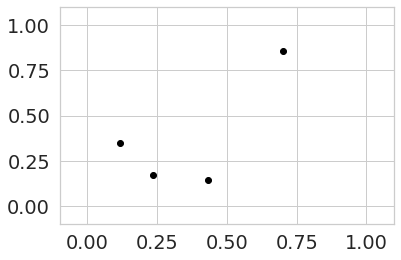

In [12]:
plt.scatter(train_inputs.cpu(), train_targets.cpu(), color='black')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$', rotation=0)
plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))

In [13]:
from conformalbo.ratio_estimation import RatioEstimator, optimize_acqf_sgld

def run_datashift_opt(seed, acqf="ei"):
    def draw_plot(ax):
        std_scale = stats.norm.ppf(1 - alpha / 2.)
        # plot p(f | x, D)
        ax.plot(grid_inputs.cpu(), y_hat_mean, color='blue', linewidth=1, zorder=4)
        ax.fill_between(
            grid_inputs.view(-1).cpu(),
            y_hat_mean - std_scale * f_hat_std,
            y_hat_mean + std_scale * f_hat_std,
            color='blue', alpha=0.25,
            label=r'$p(f | x, \mathcal{D})$',
        )
        
        # plot C_\alpha(x)
#         ax.plot(all_inputs.view(-1).cpu(), grid_lb.view(-1).cpu(), color='blueviolet', linestyle='--')
#         ax.plot(all_inputs.view(-1).cpu(), grid_ub.view(-1).cpu(), color='blueviolet', linestyle='--')
        ax.fill_between(grid_inputs.view(-1).cpu(), grid_lb.view(-1).cpu(), grid_ub.view(-1).cpu(),
                       color='blueviolet', alpha=0.125)
        ax.fill_between(grid_inputs.view(-1).cpu(), conf_lb.view(-1).cpu(), conf_ub.view(-1).cpu(),
                       color='blueviolet', alpha=0.25, label=r'$\mathcal{C}_\alpha(x)$')
#         grid_sample_x = grid_inputs.expand(-1, grid_res).cpu().view(-1)
#         grid_sample_y = target_grid.contiguous().cpu().view(-1)
#         grid_sample_alpha = conf_pred_mask.cpu().view(-1)
#         ax.scatter(grid_sample_x, grid_sample_y, s=8, alpha=grid_sample_alpha, color='blueviolet', marker='+')

        # plot a(x)
        ax.plot(grid_inputs.cpu(), acq_vals.cpu(), color='green', zorder=5, linewidth=2, label=r'$a(x)$')
        ax.scatter(input_query.cpu(), target_query.cpu(), marker='x', color='red', zorder=5,
                   s=32, linewidth=2)
        ax.scatter(opt_x.cpu().view(-1), opt_y.cpu().view(-1), marker='x', color='red', zorder=5,
                   s=16, linewidth=1)

        # plot observed
        ax.scatter(all_inputs.cpu(), all_targets.cpu(), edgecolors='black', facecolors='black', s=32, zorder=3)
#         ax.scatter(val_inputs.cpu(), val_targets.cpu(), edgecolors='black', facecolors='none', s=32, zorder=3)

        # plot true function
        ax.plot(grid_inputs.cpu(), y_norm(grid_f), color='black', linestyle='--')

        ax.set_ylim((-2.1, 2.1))

        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$', rotation=0)
        
        #plot r(x)
        if density_ratio is not None:
            ax_2 = ax.twinx()
            ax_2.plot(grid_inputs.cpu(), density_ratio.log(), color='darkorange', zorder=6, linewidth=2, label='r(x)')
            ax_2.set_ylabel(r'$\log r(x)$', color='darkorange')
            ax_2.tick_params(axis='y', labelcolor='darkorange')
#         ax.legend(ncol=2, loc='lower center')
#         ax.set_title(f't={round_idx}, alpha={alpha:0.2f}')
        return ax

    print(f"seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    grid_x = np.linspace(*x_bounds, 64)
    grid_f = obj_fn(grid_x)
    grid_y = grid_f + noise_scale * np.random.randn(*grid_f.shape)
    
    cutoff = np.max(np.where(grid_x < -8))
    x_min, y_min = grid_x.min(0), grid_y.min(0)
    x_range, y_range = grid_x.max(0) - x_min, grid_y.max(0) - y_min

    x_norm = Normalizer(
        loc=x_min + 0.5 * x_range,
        scale=x_range / 2.,
    )
    y_norm = Normalizer(
        loc=y_min + 0.5 * y_range,
        scale=y_range / 2.,
    )

#     train_x = x[:cutoff]
#     train_y = y[:cutoff]

    grid_inputs = torch.tensor(x_norm(grid_x), device=DEVICE, dtype=dtype).view(-1, 1)
    grid_targets = torch.tensor(y_norm(grid_y), device=DEVICE, dtype=dtype).view(-1, 1)
    
    all_inputs = grid_inputs[:cutoff]
    all_targets = grid_targets[:cutoff]

#     new_split = DataSplit(
#     all_inputs[:cutoff].cpu().numpy(), all_targets[:cutoff].cpu().numpy()
#     )
#     train_split, val_split, test_split = update_splits(
#         train_split=DataSplit(),
#         val_split=DataSplit(),
#         test_split=DataSplit(),
#         new_split=new_split,
#         holdout_ratio=0.2
#     )
#     train_split, val_split, test_split = splits
    
    rx_estimator = None
    optimize_callback = None
    
    conformal_kwargs = dict(
        alpha=None,
        temp=temp,
        grid_res=grid_res,
        max_grid_refinements=max_grid_refinements,
        ratio_estimator=rx_estimator,
    )

#     sampler = SobolQMCNormalSampler(mc_samples)
    sampler = IIDNormalSampler(mc_samples)
    if acqf == 'ei':
        acqf_init = lambda gp, best_f: qExpectedImprovement(
            gp,
            best_f=output_dict['norm_f_queries'][round_idx],
            sampler=sampler
        )
    elif acqf == "nei":
        acqf_init = lambda gp, best_f: qNoisyExpectedImprovement(
            gp, X_baseline=all_inputs, sampler=sampler, prune_baseline=True
        )
    elif acqf == "ucb":
        acqf_init = lambda gp, best_f: UpperConfidenceBound(gp, beta=1.)
    elif acqf == "kg":
        acqf_init = lambda gp, best_f: qKnowledgeGradient(
            model=gp,
            current_value=output_dict['norm_f_queries'][round_idx],
            num_fantasies=None,
            sampler=sampler,
        )
    elif acqf == 'conformal_ei':
        def acqf_init(gp, best_f):
            acqf = qConformalExpectedImprovement(**conformal_kwargs, model=gp, sampler=sampler,
                                                 ratio_estimator=rx_estimator)
            return acqf
    elif acqf == "conformal_nei":
        def acqf_init(gp, best_f):
            acqf = qConformalNoisyExpectedImprovement(**conformal_kwargs, model=gp, sampler=sampler,
                                                      ratio_estimator=rx_estimator)
            return acqf
    elif acqf == "conformal_ucb":
        def acqf_init(gp, best_f):
            acqf = qConformalUpperConfidenceBound(**conformal_kwargs, model=gp, beta=1., sampler=sampler)
            return acqf
    elif acqf == "conformal_kg":
        def acqf_init(gp, best_f):
            acqf = qConformalKnowledgeGradient(
                **conformal_kwargs,
                model=gp,
                current_value=None,
                num_fantasies=None,
                sampler=sampler,
            )
            return acqf
            
    
    output_dict = {
        'f_queries': torch.empty(num_rounds + 1),
        'norm_f_queries': torch.empty(num_rounds + 1),
        'cred_cvrg': torch.empty(num_rounds),
        'conf_cvrg': torch.empty(num_rounds),
        'alpha': torch.empty(num_rounds),
    }
    output_dict['f_queries'][0] = grid_f[:cutoff].max().item()
    output_dict['norm_f_queries'][0] = y_norm(grid_f[:cutoff].max()).item()
    
    for round_idx in range(num_rounds):
        perm = np.random.permutation(np.arange(all_inputs.size(0)))
        num_test = math.ceil(0.2 * all_inputs.size(0))
        num_train = all_inputs.size(0) - num_test
#         print(f"train: {num_train}, test: {num_test}")

        val_inputs, val_targets = all_inputs[perm][:num_test], all_targets[perm][:num_test]
        train_inputs, train_targets = all_inputs[perm][num_test:], all_targets[perm][num_test:]
                   
        alpha = 1 / math.sqrt(train_inputs.size(0))

        # fit GP only to train split
        matern_gp = SingleTaskGP(
            train_X=train_inputs,
            train_Y=train_targets,
            likelihood=GaussianLikelihood(noise_constraint=Interval(5e-2, 0.5)),
        ).to(DEVICE)
        mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
        fit_gpytorch_model(mll)
        matern_gp.requires_grad_(False)
        
        # assess coverage
        matern_gp.eval()
        with torch.no_grad():
            cred_cvrg, conf_cvrg = assess_coverage(
                matern_gp, val_inputs, val_targets, alpha, temp=1e-6,
                grid_res=grid_res, max_grid_refinements=4
            )
        
        # fit GP to all data
        matern_gp = SingleTaskGP(
            train_X=all_inputs,
            train_Y=all_targets,
            likelihood=GaussianLikelihood(noise_constraint=Interval(5e-2, 0.2)),
        ).to(DEVICE)
        mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
        fit_gpytorch_model(mll)
        matern_gp.requires_grad_(False)
        
        # prepare ratio estimator
        if acqf.startswith('conformal_'):
            rx_estimator = RatioEstimator(in_size=all_inputs.shape[-1], device=DEVICE, dtype=dtype)
            optimize_callback = rx_estimator.optimize_callback
            rx_estimator.dataset._update_splits(
                DataSplit(all_inputs.view(-1, 1).cpu(), torch.zeros(all_inputs.size(0), 1))
            )
            conformal_kwargs['ratio_estimator'] = rx_estimator
        
        alpha = 1 / math.sqrt(all_inputs.size(0))
        conformal_kwargs['alpha'] = alpha
        
        # get next point
        acq_fn = acqf_init(matern_gp, train_targets.max())
        if acqf.startswith('conformal_'):
            opt_x, opt_y = optimize_acqf_sgld(acq_fn, input_bounds, batch_size, num_restarts=num_restarts, raw_samples=mc_samples,
                                        options=dict(callback=optimize_callback, disp=False, ftol=1e-12),
                                        return_best_only=False)
        else:
            opt_x, opt_y = optimize_acqf(acq_fn, input_bounds, batch_size, num_restarts=num_restarts, raw_samples=mc_samples,
                                        options=dict(callback=optimize_callback, disp=False, ftol=1e-12),
                                        return_best_only=False)
        
        input_query = opt_x.flatten(0, -3)[opt_y.flatten().argmax()]
        x_query = x_norm.inv_transform(input_query.detach().cpu().numpy())
        f_query = obj_fn(x_query)
        y_query = f_query + noise_scale * np.random.randn(*f_query.shape)
        target_query = torch.tensor(y_norm(y_query), device=DEVICE, dtype=dtype)
        
        all_inputs = torch.cat([all_inputs, input_query.reshape(-1, 1)])
        all_targets = torch.cat([all_targets, target_query.reshape(-1, 1)])
        
#         all_inputs, idxs = torch.sort(all_inputs, dim=0)
#         all_targets = all_targets[idxs.squeeze(-1)]
        
        # log result
        output_dict['f_queries'][round_idx + 1] = f_query.max().item()
        output_dict['norm_f_queries'][round_idx + 1] = y_norm(f_query.max()).item()
        output_dict['cred_cvrg'][round_idx] = cred_cvrg
        output_dict['conf_cvrg'][round_idx] = conf_cvrg
        output_dict['alpha'][round_idx] = alpha
        
        density_ratio = None
        if rx_estimator is not None:
            density_ratio = rx_estimator(grid_inputs).cpu()
#             log_imp_weights = (density_ratio / density_ratio.sum()).log()
            
#         if acqf.startswith('conformal_'):
#             rx_estimator.dataset._update_splits(
#                 DataSplit(input_query.reshape(-1, 1).cpu(), torch.ones(1, 1)))

        # try drawing a plot
        if (round_idx + 1) % plot_interval == 0:
            print(f'GP noise: {matern_gp.likelihood.noise.item():0.4f}')
#             try:
            with torch.no_grad():
                f_hat_dist = matern_gp(grid_inputs)
                y_hat_dist = matern_gp.likelihood(f_hat_dist)
                f_hat_mean = f_hat_dist.mean.cpu()
                f_hat_std = f_hat_dist.variance.sqrt().cpu()
                y_hat_mean = f_hat_mean.cpu()
                y_hat_std = y_hat_dist.variance.sqrt().cpu()
                acq_vals = acq_fn(grid_inputs[:, None])
                grid_sampler = IIDNormalSampler(
                    grid_res, resample=False, collapse_batch_dims=True
                )
#                     grid_sampler = IIDNormalSampler(grid_res, resample=True)
                target_grid, _, conf_pred_mask, _, _ = construct_conformal_bands(
                    matern_gp, grid_inputs[:, None], alpha, temp=1e-6,
                    grid_res=grid_res, max_grid_refinements=4, sampler=grid_sampler,
                    ratio_estimator=rx_estimator
                )
                grid_lb = target_grid.min(-3)[0]
                grid_ub = target_grid.max(-3)[0]
                conf_lb, conf_ub = conf_mask_to_bounds(target_grid, conf_pred_mask)

            if rx_estimator is not None:
                print(f'[Iterates] {rx_estimator.dataset.cls_train_split[0].shape[0]} train, {rx_estimator.dataset.cls_val_split[0].shape[0]} val, {rx_estimator.dataset.cls_test_split[0].shape[0]} test')
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(1, 1, 1)
            draw_plot(ax)
            plt.tight_layout()
            if save_figs:
                plt.savefig(f'./figures/synth-example_prediction-sets_seed-{seed}_round-{round_idx}.pdf')
#             except Exception as e:
#                 print(e)
#                 continue


    plt.show()

    return output_dict

### Global settings

In [14]:
num_trials = 4
mc_samples = 32
grid_res = 128
temp = 0.25
max_grid_refinements = 0
num_rounds = 16
num_restarts = 4
batch_size = 1
plot_interval = 4
save_figs = False

seed: 0
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 914 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 918 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 922 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 926 train, 0 val, 0 test


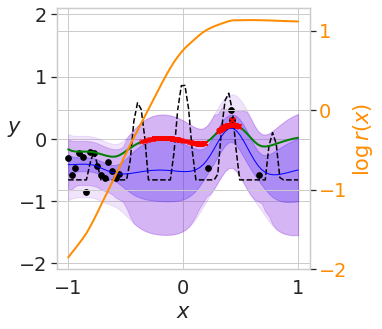

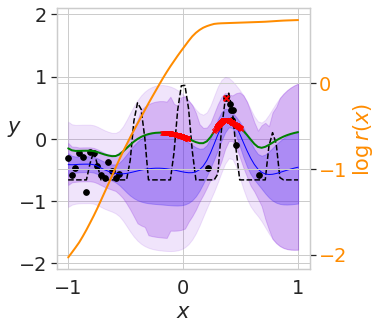

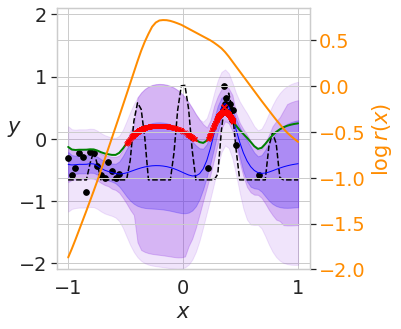

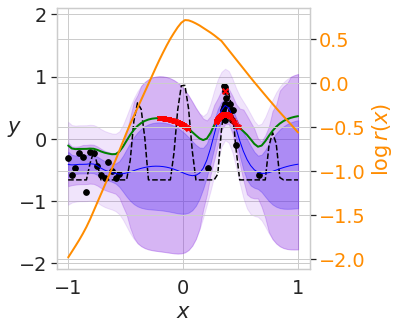

seed: 1
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0831
[Iterates] 914 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.1393
[Iterates] 918 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0553
[Iterates] 922 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0569
[Iterates] 926 train, 0 val, 0 test


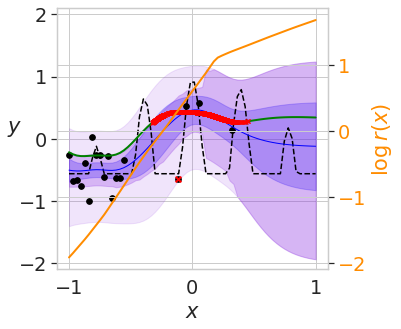

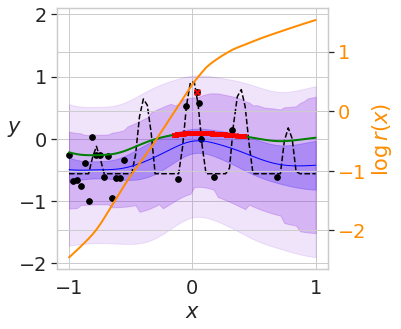

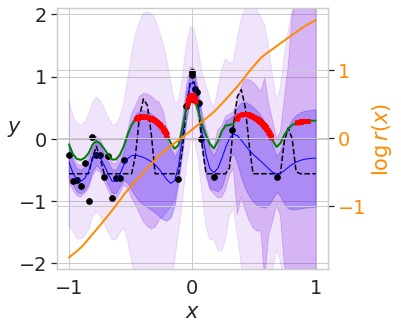

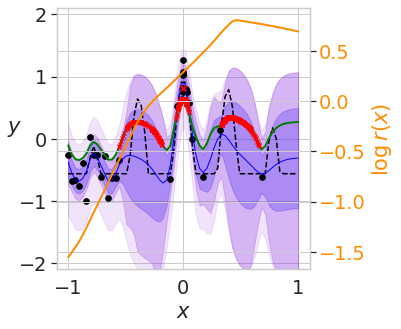

seed: 2
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 914 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0823
[Iterates] 918 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 922 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 926 train, 0 val, 0 test


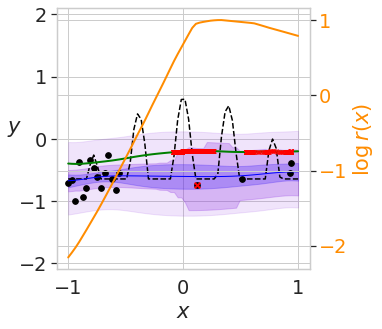

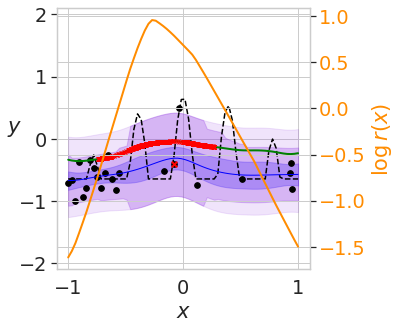

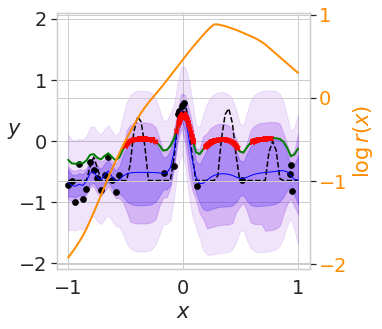

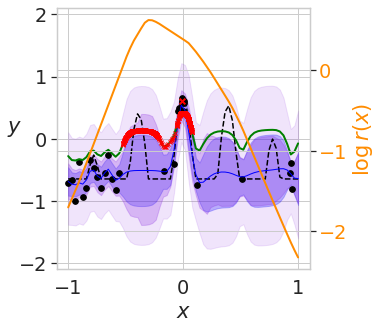

seed: 3
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 914 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0839
[Iterates] 918 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0839
[Iterates] 922 train, 0 val, 0 test
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
256 0.05 0.001
GP noise: 0.0500
[Iterates] 926 train, 0 val, 0 test


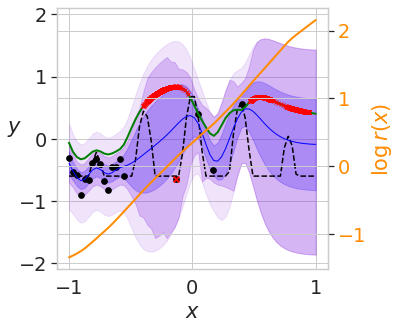

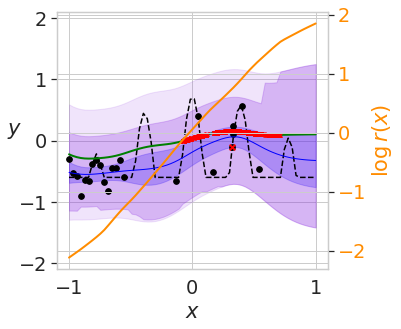

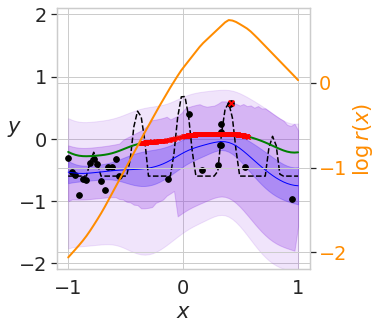

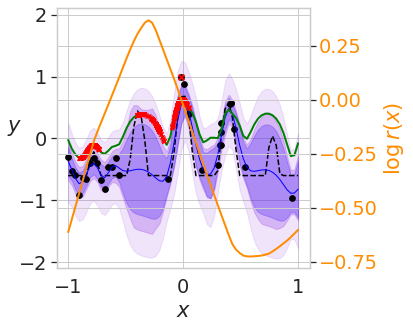

In [15]:
conformal_out = [
    run_datashift_opt(
        seed, acqf="conformal_ucb"
    ) for seed in range(num_trials)
]

seed: 0
GP noise: 0.0500
GP noise: 0.0619
GP noise: 0.0500
GP noise: 0.0500


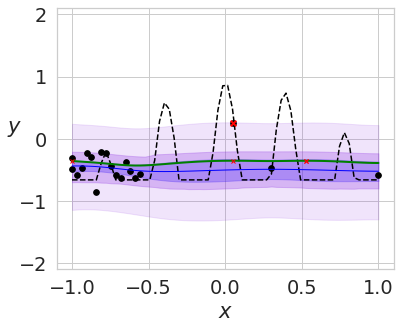

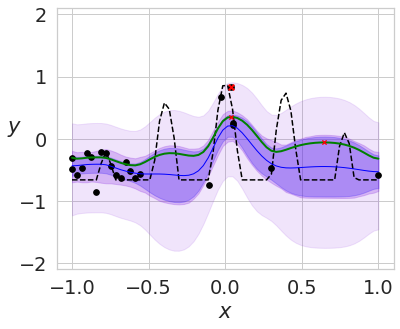

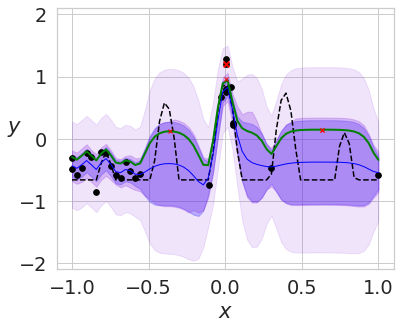

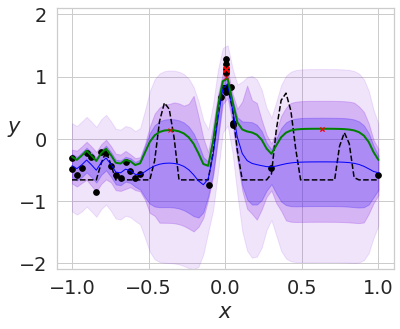

seed: 1
GP noise: 0.0803
GP noise: 0.0649
GP noise: 0.0512
GP noise: 0.0500


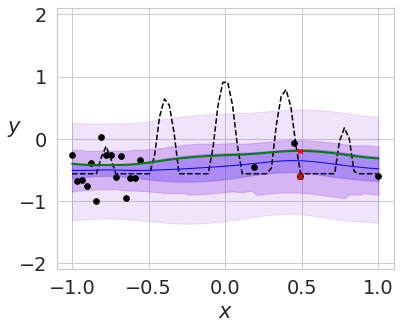

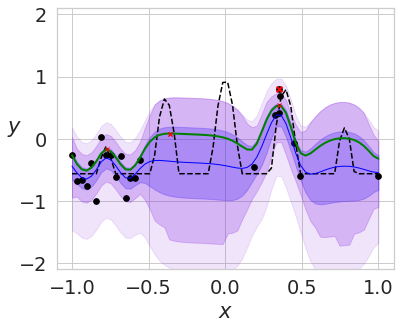

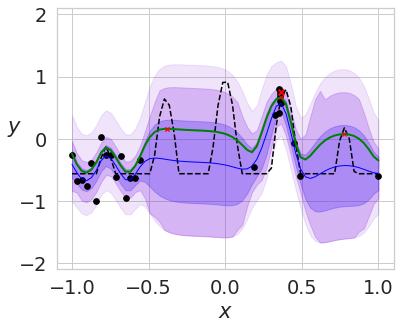

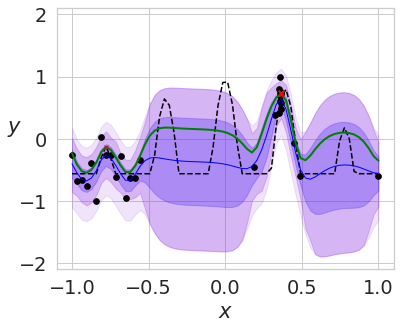

seed: 2
GP noise: 0.0500
GP noise: 0.0500
GP noise: 0.0500
GP noise: 0.0500


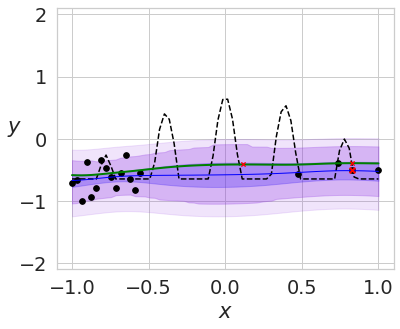

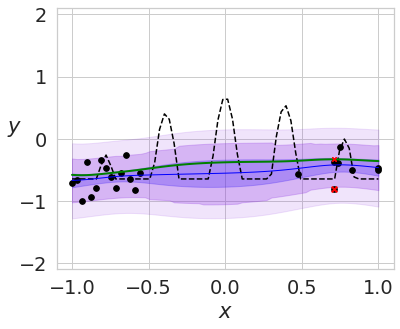

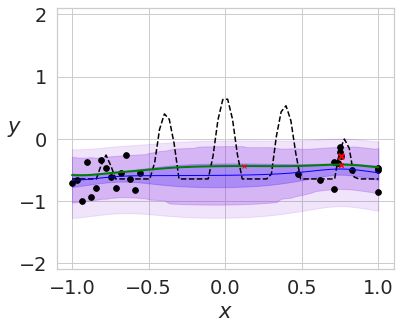

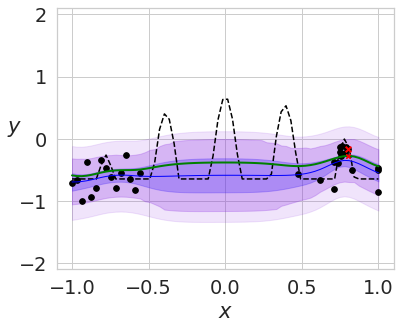

seed: 3
GP noise: 0.0500
GP noise: 0.0617
GP noise: 0.0500
GP noise: 0.0500


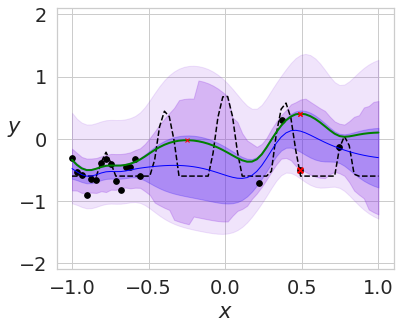

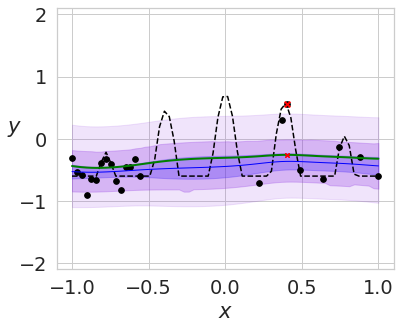

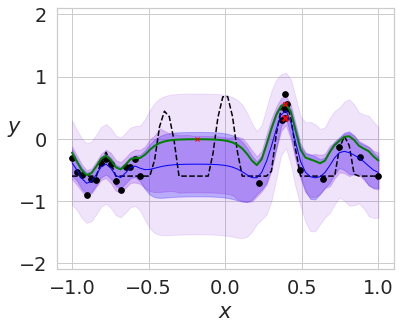

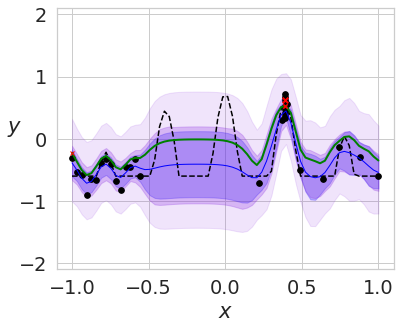

In [16]:
std_out = [
    run_datashift_opt(
        seed, acqf="ucb"
    ) for seed in range(num_trials)
]

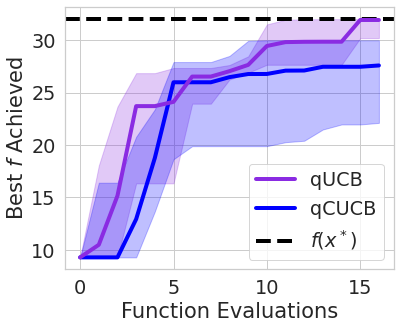

In [17]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

conf_best_f = torch.stack([d['f_queries'] for d in conformal_out]).cummax(1)[0]
std_best_f = torch.stack([d['f_queries'] for d in std_out]).cummax(1)[0]

plt.plot(conf_best_f.quantile(0.5, dim=0), label = "qUCB", color='blueviolet', linewidth=4, zorder=3)
plt.fill_between(torch.arange(conf_best_f.size(-1)), 
                 conf_best_f.quantile(0.2, dim=0), 
                 conf_best_f.quantile(0.8, dim=0), 
                 alpha = 0.25, color='blueviolet')
plt.plot(std_best_f.quantile(0.5, dim=0), label = "qCUCB", color='blue', linewidth=4, zorder=2)
plt.fill_between(torch.arange(std_best_f.size(-1)), 
                 std_best_f.quantile(0.2, dim=0), 
                 std_best_f.quantile(0.8, dim=0), 
                 alpha = 0.25, color='blue')

plt.xlim(plt.xlim())
plt.hlines(32., *plt.xlim(), linestyle='--', color='black', linewidth=4, label=r'$f(x^*)$', zorder=1)

plt.legend()
plt.xlabel("Function Evaluations")
plt.ylabel(r"Best $f$ Achieved")
plt.tight_layout()
# plt.savefig('./figures/synth-example_best-f.pdf')

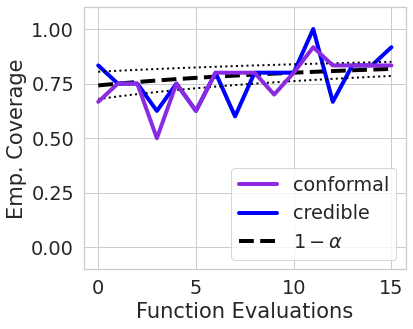

In [18]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

conf_cvrg = torch.stack([d['conf_cvrg'] for d in conformal_out])
cred_cvrg = torch.stack([d['cred_cvrg'] for d in conformal_out])
alpha = torch.stack([d['alpha'] for d in conformal_out])

plt.plot(conf_cvrg.quantile(0.5, dim=0), label = "conformal", color='blueviolet', linewidth=4, zorder=3)
# plt.fill_between(torch.arange(conf_cvrg.size(-1)), 
#                  conf_cvrg.quantile(0.2, dim=0), 
#                  conf_cvrg.quantile(0.8, dim=0), 
#                  alpha = 0.25, color='blueviolet')
plt.plot(cred_cvrg.quantile(0.5, dim=0), label = "credible", color='blue', linewidth=4, zorder=2)
# plt.fill_between(torch.arange(conf_cvrg.size(-1)), 
#                  cred_cvrg.quantile(0.2, dim=0), 
#                  cred_cvrg.quantile(0.8, dim=0), 
#                  alpha = 0.25, color='blue')

cov_lb = 1 - alpha + 1 / (1 / alpha ** 2 + 1)
cov_ub = 1 - alpha - 1 / (1 / alpha ** 2 + 1)
plt.plot(torch.arange(alpha.size(-1)), cov_lb.mean(0),
         color='black', linestyle='dotted', linewidth=2)
plt.plot(torch.arange(alpha.size(-1)), cov_ub.mean(0),
         color='black', linestyle='dotted', linewidth=2)
plt.plot(torch.arange(alpha.size(-1)), (1 - alpha).mean(0),
         color='black', linestyle='--', linewidth=4, label=r'$1 - \alpha$', zorder=1)

plt.legend(ncol=1, loc='lower right')
plt.xlabel("Function Evaluations")
plt.ylabel("Emp. Coverage")
plt.ylim((-0.1, 1.1))
plt.tight_layout()
# plt.savefig('./figures/synth-example_emp-cvrg.pdf')

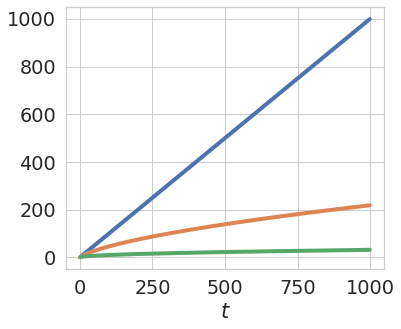

In [19]:
# plt.figure(figsize=(6, 5))
# t = np.arange(1, 1000).astype(float)
# plt.plot(t, t, label=r'$t$', linewidth=4)
# plt.plot(t, (t * np.log(t) ** 2) ** 0.5, label=r'$\sqrt{t\log^2 t}$', linewidth=4)
# plt.plot(t, t ** 0.5, label=r'$\sqrt{t}$', linewidth=4)
# plt.xlabel(r'$t$')
# # plt.legend(ncol=3)
# plt.tight_layout()